We have the data stored in separate tables in the duckdb database

We need to merge the tables to create one joined view with the neccessary data used for analysis

In [1]:
import duckdb

con = duckdb.connect("../db/instacart.duckdb")

JOIN THE TABLES

Combining prior and train product lines into one consolidated product level table

In [2]:
'''con.execute("""
    CREATE TABLE order_products_consolidated AS
            SELECT * from order_products_prior
            UNION ALL
            SELECT * FROM order_products_train
""")'''

'con.execute("""\n    CREATE TABLE order_products_consolidated AS\n            SELECT * from order_products_prior\n            UNION ALL\n            SELECT * FROM order_products_train\n""")'

In [3]:
df = con.execute("""
                SELECT
                    opc.order_id,
                    opc.product_id,
                    opc.add_to_cart_order,
                    opc.reordered,
                    o.user_id,
                    o.order_number,
                    o.order_dow,
                    o.order_hour_of_day,
                    o.days_since_prior_order,
                    o.eval_set,
                    p.product_name,
                    p.aisle_id,
                    p.department_id,
                    a.aisle,
                    d.department
                 FROM order_products_consolidated AS opc
                 LEFT JOIN orders as o
                    on opc.order_id = o.order_id
                 LEFT JOIN products as p
                    on opc.product_id = p.product_id
                 LEFT JOIN aisles as a
                    on p.aisle_id = a.aisle_id
                 LEFT JOIN departments as d
                    on p.department_id = d.department_id       
""").df()

In [4]:
df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,eval_set,product_name,aisle_id,department_id,aisle,department
0,51966,7821,7,0,190601,10,4,12,6.0,prior,Olive Oil & Vinegar Dressing,89,13,salad dressing toppings,pantry
1,51966,31528,8,0,190601,10,4,12,6.0,prior,Natural Emmentaler Swiss Cheese,21,16,packaged cheese,dairy eggs
2,51966,38397,9,0,190601,10,4,12,6.0,prior,Chocolate Cupcakes,8,3,bakery desserts,bakery
3,51966,24654,10,0,190601,10,4,12,6.0,prior,Potato Hot Dog Buns,43,3,buns rolls,bakery
4,51966,46605,11,0,190601,10,4,12,6.0,prior,Chocolate Croissant,93,3,breakfast bakery,bakery


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33819106 entries, 0 to 33819105
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   product_id              int64  
 2   add_to_cart_order       int64  
 3   reordered               int64  
 4   user_id                 int64  
 5   order_number            int64  
 6   order_dow               int64  
 7   order_hour_of_day       object 
 8   days_since_prior_order  float64
 9   eval_set                object 
 10  product_name            object 
 11  aisle_id                int64  
 12  department_id           int64  
 13  aisle                   object 
 14  department              object 
dtypes: float64(1), int64(9), object(5)
memory usage: 3.8+ GB


DATA EXPLORATION

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Which aisles and departments are most visited?

In [7]:
aisle_counts = df['aisle'].value_counts().sort_values(ascending=False)
aisle_counts.head(15)

aisle
fresh fruits                     3792661
fresh vegetables                 3568630
packaged vegetables fruits       1843806
yogurt                           1507583
packaged cheese                  1021462
milk                              923659
water seltzer sparkling water     878150
chips pretzels                    753739
soy lactosefree                   664493
bread                             608469
refrigerated                      599109
frozen produce                    545107
ice cream ice                     521101
crackers                          478430
energy granola bars               473835
Name: count, dtype: int64

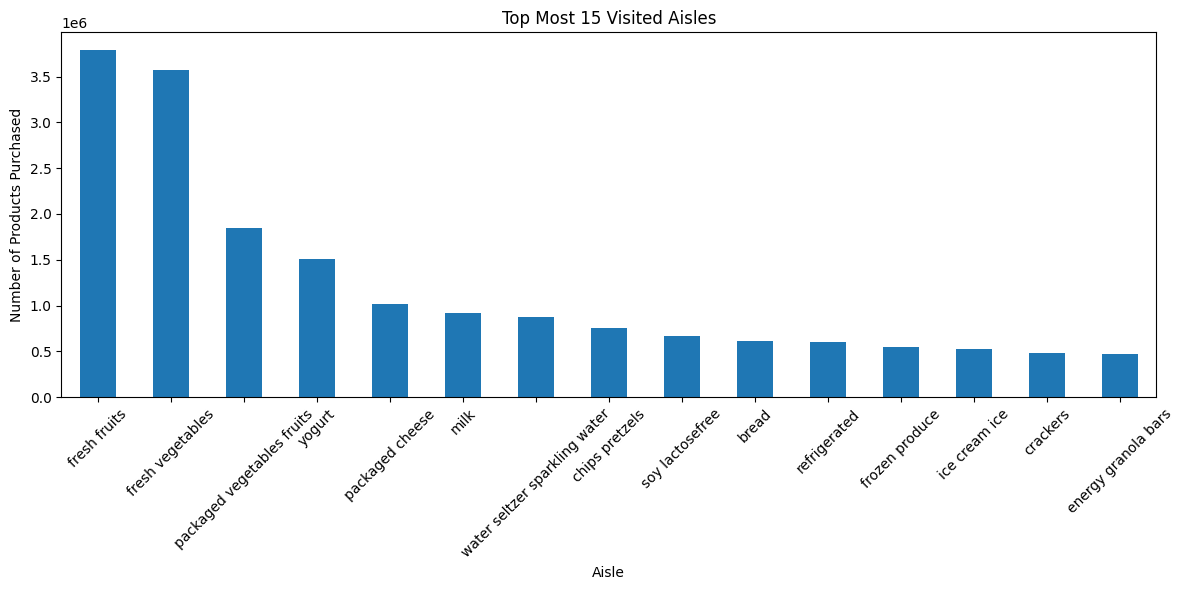

In [8]:
plt.figure(figsize=(12,6))
aisle_counts.head(15).plot(kind='bar')
plt.title("Top Most 15 Visited Aisles")
plt.xlabel('Aisle')
plt.ylabel('Number of Products Purchased')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

department
produce            9888378
dairy eggs         5631067
snacks             3006412
beverages          2804175
frozen             2336858
pantry             1956819
bakery             1225181
canned goods       1114857
deli               1095540
dry goods pasta     905340
Name: count, dtype: int64


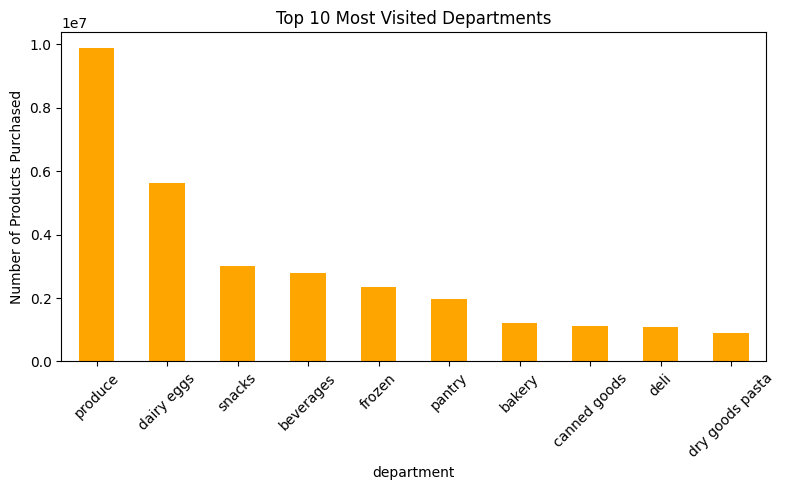

In [9]:
department_counts = df['department'].value_counts().sort_values(ascending=False)

print(department_counts.head(10))

plt.figure(figsize=(8,5))
department_counts.head(10).plot(kind="bar", color="orange")
plt.title("Top 10 Most Visited Departments")
plt.ylabel("Number of Products Purchased")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Most frequently commanded (popular) products?

In [10]:
product_counts = (
    df['product_name']
    .value_counts()
    .sort_values(ascending=False)
)
product_counts.head(20)


product_name
Banana                      491291
Bag of Organic Bananas      394930
Organic Strawberries        275577
Organic Baby Spinach        251705
Organic Hass Avocado        220877
Organic Avocado             184224
Large Lemon                 160792
Strawberries                149445
Limes                       146660
Organic Whole Milk          142813
Organic Raspberries         142603
Organic Yellow Onion        117716
Organic Garlic              113936
Organic Zucchini            109412
Organic Blueberries         105026
Cucumber Kirby               99728
Organic Fuji Apple           92889
Organic Lemon                91251
Organic Grape Tomatoes       88078
Apple Honeycrisp Organic     87272
Name: count, dtype: int64

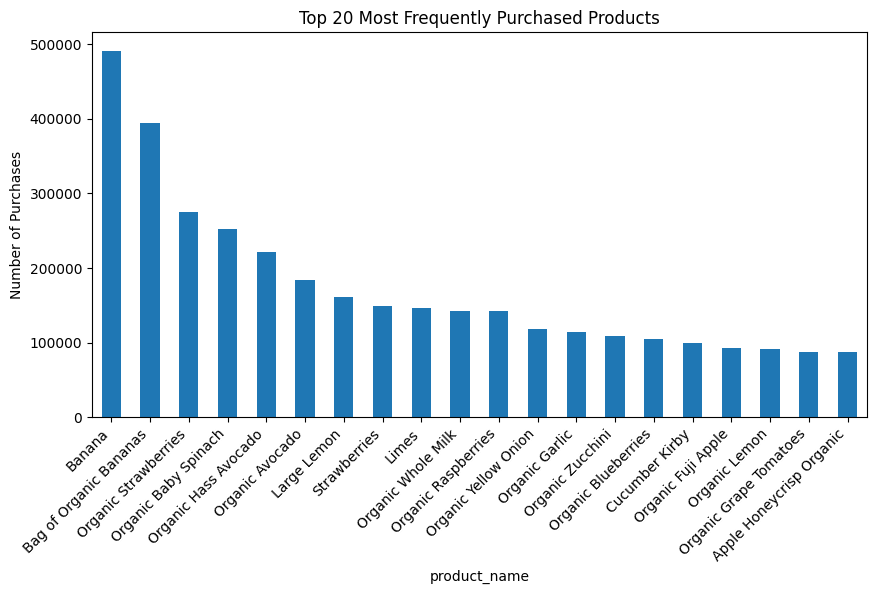

In [11]:
plt.figure(figsize=(10,5))
product_counts.head(20).plot(kind='bar')
plt.title('Top 20 Most Frequently Purchased Products')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=45, ha='right')
plt.show()

Reorder Ratio Per Department

In [12]:
reorder_dept = (
    df.groupby('department')
    .agg(total_items=('reordered','count'),
         total_orders=('reordered','sum'))
    .assign(reorder_ratio=lambda x:x['total_orders']/x['total_items'])
    .sort_values('reorder_ratio', ascending=False)
)
reorder_dept

,total_items,total_orders,reorder_ratio
department,,,
dairy eggs,5631067,3773723,0.670161
beverages,2804175,1832952,0.653651
produce,9888378,6432596,0.650521
bakery,1225181,769880,0.628381
deli,1095540,666231,0.608130
pets,102221,61594,0.602557
babies,438743,253453,0.577680
bulk,35932,20736,0.577090
snacks,3006412,1727075,0.574464


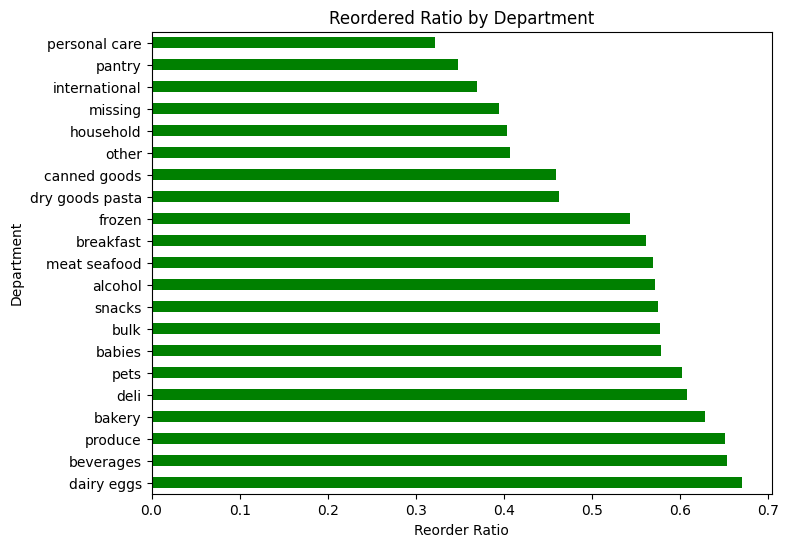

In [13]:
reorder_dept['reorder_ratio'].plot(kind='barh',figsize=(8,6),color='green')
plt.xlabel('Reorder Ratio')
plt.ylabel('Department')
plt.title('Reordered Ratio by Department')
plt.show()

Most frequent order days?

In [14]:
# select only unique orders
unique_orders = df[['order_id','order_dow']].drop_duplicates()

# count the orders by days of the week
order_per_dow = unique_orders['order_dow'].value_counts().sort_index()

# make it more readable by mapping 0-6 to day names
day_names = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

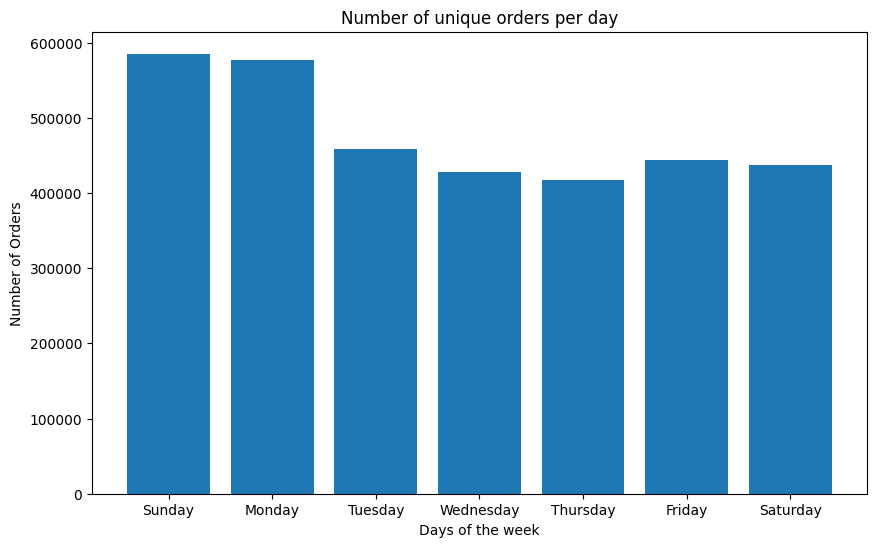

In [15]:
plt.figure(figsize=(10,6))
plt.bar(day_names,order_per_dow)
plt.xlabel('Days of the week')
plt.ylabel('Number of Orders')
plt.title('Number of unique orders per day')
plt.show()

Most frequent order time?

In [16]:
df['order_hour_of_day'] = df['order_hour_of_day'].astype(int)

In [17]:
df['order_hour_bin'] = pd.cut(df['order_hour_of_day'], bins=range(0, 25, 3), right=False)
df['order_hour_bin']

0           [12, 15)
1           [12, 15)
2           [12, 15)
3           [12, 15)
4           [12, 15)
              ...   
33819101     [9, 12)
33819102     [9, 12)
33819103     [9, 12)
33819104     [9, 12)
33819105     [9, 12)
Name: order_hour_bin, Length: 33819106, dtype: category
Categories (8, interval[int64, left]): [[0, 3) < [3, 6) < [6, 9) < [9, 12) < [12, 15) < [15, 18) < [18, 21) < [21, 24)]

In [18]:
order_counts = df[['order_id', 'order_hour_bin']].drop_duplicates() \
    .groupby('order_hour_bin')['order_id'].count()

C:\Users\elias\AppData\Local\Temp\ipykernel_43772\3641441806.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('order_hour_bin')['order_id'].count()


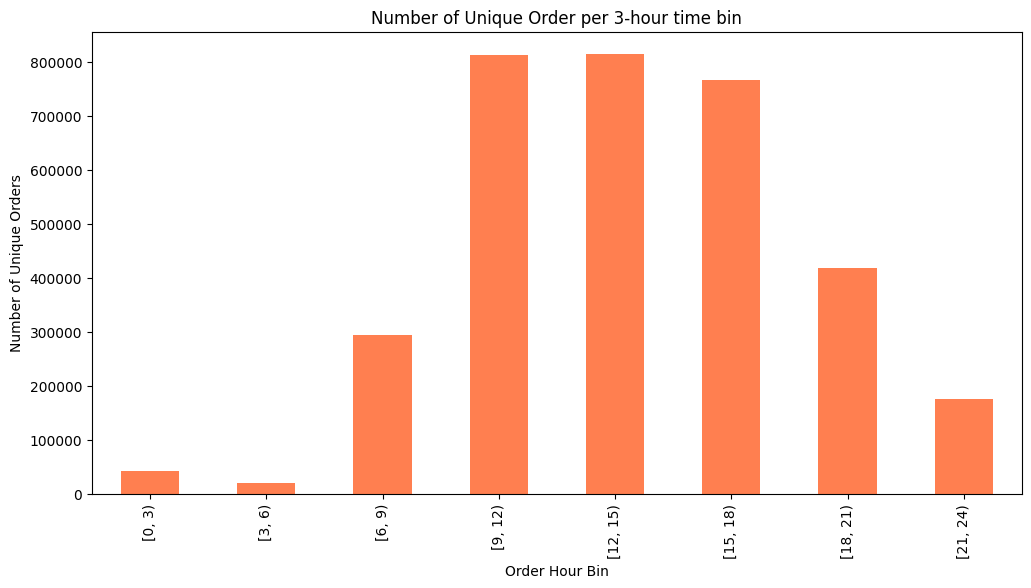

In [19]:
order_counts.plot(kind='bar', color='coral', figsize=(12,6))
plt.xlabel('Order Hour Bin')
plt.ylabel('Number of Unique Orders')
plt.title('Number of Unique Order per 3-hour time bin')
plt.show()

Segmentation of department per hours of day

In [20]:
# group by department + 3-hour bin
dept_hourly = (
    df.groupby(['order_hour_bin', 'department'])['order_id']
    .nunique()
    .reset_index(name="unique_orders")
)
dept_hourly

C:\Users\elias\AppData\Local\Temp\ipykernel_43772\3444584684.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['order_hour_bin', 'department'])['order_id']


,order_hour_bin,department,unique_orders
0,"[0, 3)",alcohol,737
1,"[0, 3)",babies,1809
2,"[0, 3)",bakery,10764
3,"[0, 3)",beverages,18987
4,"[0, 3)",breakfast,6357
...,...,...,...
163,"[21, 24)",pantry,65422
164,"[21, 24)",personal care,17992
165,"[21, 24)",pets,2667
166,"[21, 24)",produce,138632


In [21]:
top5_depts_per_bin = (
    dept_hourly
    .sort_values(['order_hour_bin', 'unique_orders'], ascending=[True, False])
    .groupby('order_hour_bin')
    .head(5)
)

top5_depts_per_bin

C:\Users\elias\AppData\Local\Temp\ipykernel_43772\359012916.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('order_hour_bin')


,order_hour_bin,department,unique_orders
19,"[0, 3)",produce,31645
7,"[0, 3)",dairy eggs,27679
3,"[0, 3)",beverages,18987
20,"[0, 3)",snacks,16772
10,"[0, 3)",frozen,15821
40,"[3, 6)",produce,14782
28,"[3, 6)",dairy eggs,13203
24,"[3, 6)",beverages,9569
41,"[3, 6)",snacks,7864
31,"[3, 6)",frozen,7611


In [22]:
# pivot for stacked barplot
pivot_top5 = top5_depts_per_bin.pivot(
    index='order_hour_bin',
    columns='department',
    values='unique_orders'
).fillna(0)

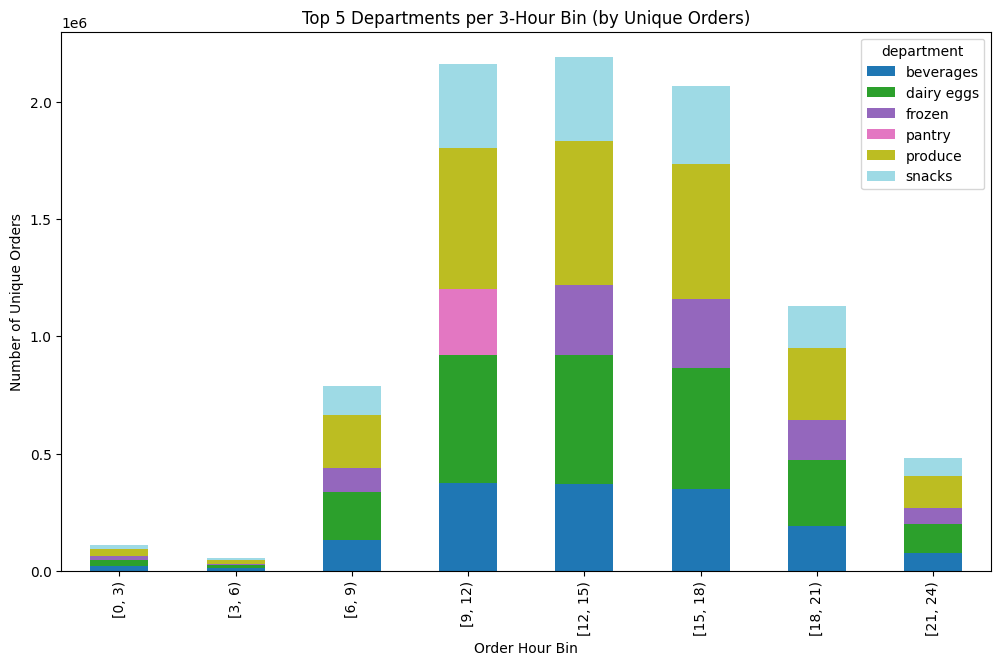

In [23]:
pivot_top5.plot(kind="bar", stacked=True, figsize=(12,7), colormap='tab20')
plt.title("Top 5 Departments per 3-Hour Bin (by Unique Orders)")
plt.ylabel("Number of Unique Orders")
plt.xlabel("Order Hour Bin")
plt.show()

Top ordering users?

In [24]:
top_users = (
    df.groupby("user_id")["order_number"]
    .max()
    .sort_values(ascending=False)
    .head(20)
)
top_users = top_users.reset_index(name='Number of Orders')
top_users

,user_id,Number of Orders
0,65666,100
1,111923,100
2,139345,100
3,36740,100
4,111739,100
5,73542,100
6,51437,100
7,86633,100
8,205972,100
9,13951,100


GROUPING PER USER

Top 10 Products Per User

In [25]:
user_product_counts = (
    df.groupby(['user_id', 'product_name'])['order_id']
    .nunique()
    .reset_index(name='purchase_count')
)
# rank products within each user
user_product_counts['rank'] = (
    user_product_counts
    .groupby('user_id')['purchase_count']
    .rank(method='dense', ascending=False)
)

In [26]:
# keep top 10
top5_products_per_user = user_product_counts[user_product_counts['rank'] <= 5]

top5_products_per_user[top5_products_per_user["user_id"] <= 5]


,user_id,product_name,purchase_count,rank
1,1,Aged White Cheddar Popcorn,3,5.0
4,1,Cinnamon Toast Crunch,4,4.0
9,1,Organic Half & Half,3,5.0
10,1,Organic String Cheese,9,3.0
14,1,Original Beef Jerky,10,2.0
...,...,...,...,...
213,5,Snow Peas,2,3.0
214,5,Tahitian Vanilla Bean Gelato,1,4.0
215,5,Tamari Gluten Free Soy Sauce,1,4.0
216,5,Uncured Genoa Salami,1,4.0


In [27]:
user_id = 1
user_top5 = top5_products_per_user[top5_products_per_user["user_id"] == user_id]
user_top5

,user_id,product_name,purchase_count,rank
1,1,Aged White Cheddar Popcorn,3,5.0
4,1,Cinnamon Toast Crunch,4,4.0
9,1,Organic Half & Half,3,5.0
10,1,Organic String Cheese,9,3.0
14,1,Original Beef Jerky,10,2.0
15,1,Pistachios,10,2.0
16,1,Soda,11,1.0
17,1,XL Pick-A-Size Paper Towel Rolls,3,5.0
18,1,Zero Calorie Cola,4,4.0


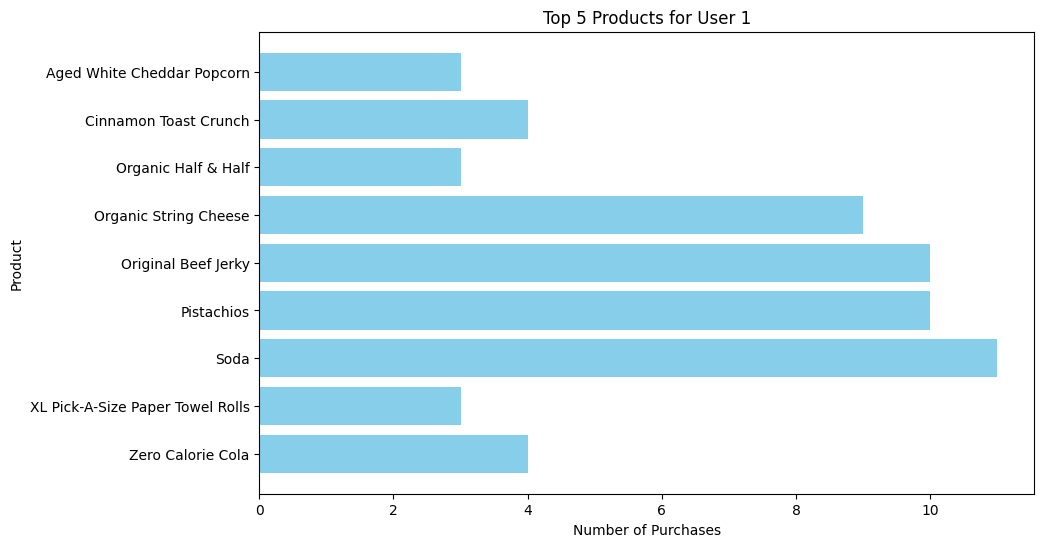

In [28]:
plt.figure(figsize=(10,6))
plt.barh(user_top5["product_name"], user_top5["purchase_count"], color="skyblue")
plt.xlabel("Number of Purchases")
plt.ylabel("Product")
plt.title(f"Top 5 Products for User {user_id}")
plt.gca().invert_yaxis()
plt.show()

Reordered products per user

In [29]:
reorderedproducts_per_user = (
    df[df["reordered"] == 1]
    .groupby(['user_id',"product_name"])["order_id"]
    .nunique()
    .reset_index(name="reorder_count")
)
# rank them per user
reorderedproducts_per_user["rank"] = (
    reorderedproducts_per_user
    .groupby("user_id")["reorder_count"]
    .rank(method="dense", ascending=False)
)

In [30]:
# keep top 5 reordered products per user
top5_reordered_per_user = reorderedproducts_per_user[reorderedproducts_per_user["rank"] <= 5]

top5_reordered_per_user.head(10)

,user_id,product_name,reorder_count,rank
1,1,Aged White Cheddar Popcorn,2,5.0
3,1,Cinnamon Toast Crunch,3,4.0
5,1,Organic Half & Half,2,5.0
6,1,Organic String Cheese,8,3.0
7,1,Original Beef Jerky,9,2.0
8,1,Pistachios,9,2.0
9,1,Soda,10,1.0
10,1,XL Pick-A-Size Paper Towel Rolls,2,5.0
11,1,Zero Calorie Cola,3,4.0
12,2,Baked Organic Sea Salt Crunchy Pea Snack,4,4.0


Product placement in cart

In [31]:
top5_preferredproducts_per_order = df[df['add_to_cart_order'] <= 5]

In [32]:
top5_preferredproducts_per_order.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,eval_set,product_name,aisle_id,department_id,aisle,department,order_hour_bin
5,51967,45106,1,0,159481,1,0,11,NaN,prior,Low Fat Strawberry Yogurt Tubes,120,16,yogurt,dairy eggs,"[9, 12)"
6,51967,15438,2,0,159481,1,0,11,NaN,prior,"Mayonnaise, Classic",72,13,condiments,pantry,"[9, 12)"
7,51967,12015,3,0,159481,1,0,11,NaN,prior,Asparagus Spears,83,4,fresh vegetables,produce,"[9, 12)"
8,51967,46906,4,0,159481,1,0,11,NaN,prior,Grape White/Green Seedless,24,4,fresh fruits,produce,"[9, 12)"
9,51967,33443,5,0,159481,1,0,11,NaN,prior,Passion Fruit,24,4,fresh fruits,produce,"[9, 12)"
12,51968,46979,1,1,4671,26,2,16,2.0,prior,Asparagus,83,4,fresh vegetables,produce,"[15, 18)"
13,51968,47209,2,1,4671,26,2,16,2.0,prior,Organic Hass Avocado,24,4,fresh fruits,produce,"[15, 18)"
14,51968,10691,3,1,4671,26,2,16,2.0,prior,Gluten Free Rigatoni,131,9,dry pasta,dry goods pasta,"[15, 18)"
15,51968,39097,4,1,4671,26,2,16,2.0,prior,Gluten Free White Sandwich Bread,112,3,bread,bakery,"[15, 18)"
16,51969,39911,1,0,91961,8,3,15,11.0,prior,Sensible Foods Kale Veggie Burgers - 4 CT,42,1,frozen vegan vegetarian,frozen,"[15, 18)"


In [33]:
user_early_product_counts = (
    top5_preferredproducts_per_order.groupby(['user_id', 'product_name'])['order_id']
    .nunique()
    .reset_index(name='count_in_top5')
)
user_early_product_counts.head(10)

,user_id,product_name,count_in_top5
0,1,0% Greek Strained Yogurt,2
1,1,Aged White Cheddar Popcorn,2
2,1,Bag of Organic Bananas,1
3,1,Cinnamon Toast Crunch,1
4,1,Creamy Almond Butter,1
5,1,Milk Chocolate Almonds,2
6,1,Organic Fuji Apples,1
7,1,Organic Half & Half,1
8,1,Organic String Cheese,9
9,1,Organic Unsweetened Vanilla Almond Milk,1


In [34]:
# first, rank products per user by how often they were in the top-5 cart slots
user_top5_early_cart = (
    user_early_product_counts
    .sort_values(['user_id', 'count_in_top5'], ascending=[True, False])
    .groupby('user_id')
    .head(5)
)
user_top5_early_cart

,user_id,product_name,count_in_top5
12,1,Soda,11
8,1,Organic String Cheese,9
10,1,Original Beef Jerky,8
11,1,Pistachios,8
13,1,XL Pick-A-Size Paper Towel Rolls,3
...,...,...,...
6839246,206209,Calcium Enriched 100% Lactose Free Fat Free Milk,10
6839251,206209,Diet Pepsi Pack,10
6839254,206209,French Loaf,7
6839245,206209,Banana,4


In [35]:
sample_users = [1, 2, 3]

sample_user_top5 = user_top5_early_cart[user_top5_early_cart['user_id'].isin(sample_users)]

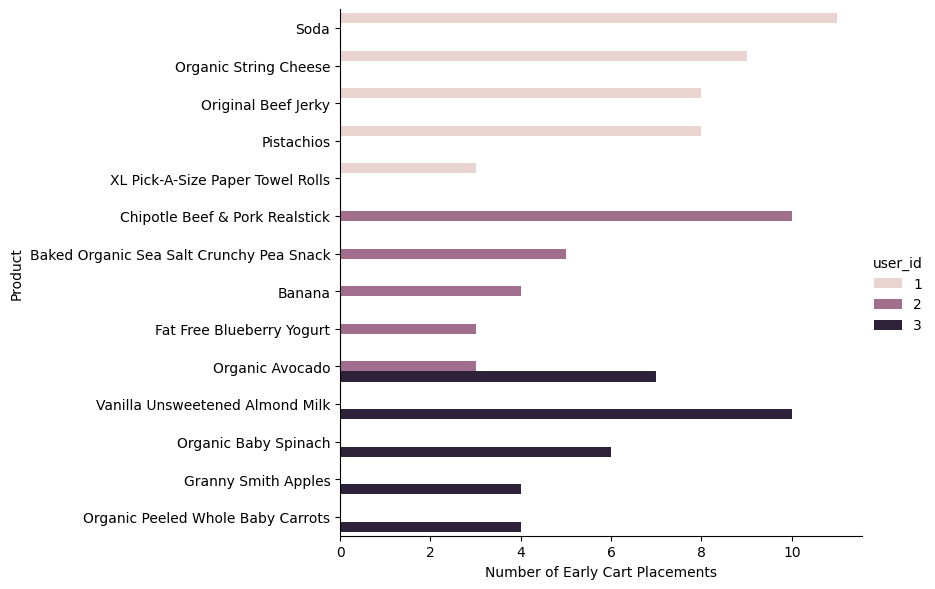

In [36]:
g = sns.catplot(
    data=sample_user_top5,
    x="count_in_top5",
    y="product_name",
    hue="user_id",
    kind="bar",
    height=6,
    aspect=1.5
)
g.set_axis_labels("Number of Early Cart Placements", "Product")
g.set_titles("Top 5 Early Cart Products per Sample User")
plt.show()

Weekly Ordering Patterns (Preferred Days)

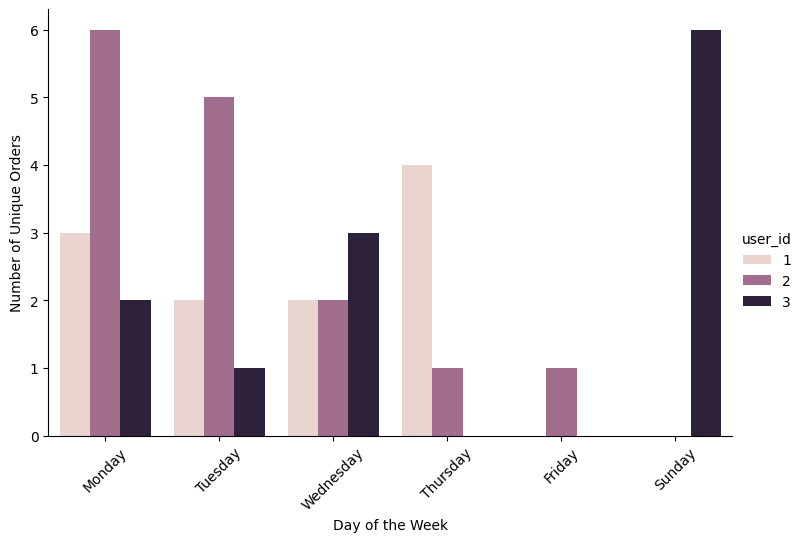

In [37]:
# weekly ordering pattern for the sample users
weekly_pattern = (
    df[df['user_id'].isin(sample_users)]
    .groupby(['user_id', 'order_dow'])['order_id']
    .nunique()
    .reset_index(name="unique_orders")
)

# map dow numbers to names
dow_map = {0:'Sunday', 1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday'}
weekly_pattern['order_dow'] = weekly_pattern['order_dow'].map(dow_map)

# plot
g = sns.catplot(
    data=weekly_pattern,
    x="order_dow",
    y="unique_orders",
    hue="user_id",
    kind="bar",
    height=5,
    aspect=1.5
)
g.set_axis_labels("Day of the Week", "Number of Unique Orders")
g.set_titles("Weekly Ordering Pattern per User")
plt.xticks(rotation=45)
plt.show()


Preferred Ordering Time Ranges (binned in 3-hour intervals)

In [38]:
time_pattern = (
    df[df['user_id'].isin(sample_users)]
    .groupby(['user_id','order_hour_bin'])['order_id']
    .nunique()
    .reset_index(name='unique_orders')
)
time_pattern

C:\Users\elias\AppData\Local\Temp\ipykernel_43772\987402752.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['user_id','order_hour_bin'])['order_id']


,user_id,order_hour_bin,unique_orders
0,1,"[0, 3)",0
1,1,"[3, 6)",0
2,1,"[6, 9)",6
3,1,"[9, 12)",1
4,1,"[12, 15)",2
5,1,"[15, 18)",2
6,1,"[18, 21)",0
7,1,"[21, 24)",0
8,2,"[0, 3)",0
9,2,"[3, 6)",0


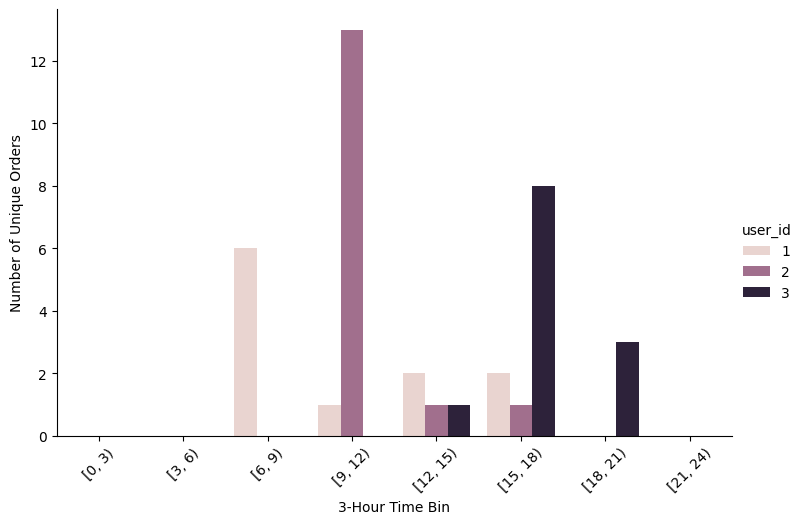

In [39]:
# plot
g = sns.catplot(
    data=time_pattern,
    x="order_hour_bin",
    y="unique_orders",
    hue="user_id",
    kind="bar",
    height=5,
    aspect=1.5
)
g.set_axis_labels("3-Hour Time Bin", "Number of Unique Orders")
g.set_titles("Preferred Ordering Times per User")
plt.xticks(rotation=45)
plt.show()

Days since Last Order

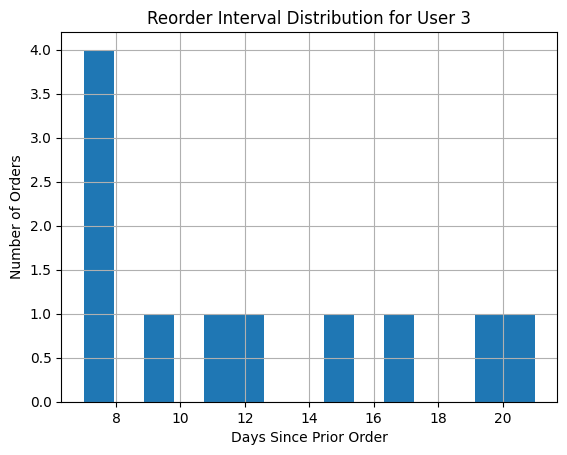

In [40]:
sample_user = 3
user_orders = (
    df[df['user_id'] == sample_user]
    .drop_duplicates(subset='order_id')
)

user_orders['days_since_prior_order'].hist(bins=15)
plt.xlabel("Days Since Prior Order")
plt.ylabel("Number of Orders")
plt.title(f"Reorder Interval Distribution for User {sample_user}")
plt.show()

BUILDING THE MODEL

Feature Selection

In [41]:
# generating user_product pairs
user_product_pairs = (
    df[df['eval_set']=='prior'][['user_id','product_id']]
    .drop_duplicates()
)
user_product_pairs.head()

,user_id,product_id
0,190601,7821
1,190601,31528
2,190601,38397
3,190601,24654
4,190601,46605


In [42]:
labels = (
    df[df['eval_set'] == 'train'][['user_id', 'product_id']]
    .drop_duplicates()
    .assign(y=1)
)
labels

,user_id,product_id,y
32354319,197376,32486,1
32354320,197376,21616,1
32354321,197376,32016,1
32354322,197376,28199,1
32354323,197376,17872,1
...,...,...,...
33819015,92047,18479,1
33819016,92047,24184,1
33819017,92047,49683,1
33819018,92047,38383,1


In [43]:
training_set = user_product_pairs.merge(labels,on=['user_id','product_id'], how='left')
training_set['y'] = training_set['y'].fillna(0)
training_set

,user_id,product_id,y
0,190601,7821,0.0
1,190601,31528,0.0
2,190601,38397,0.0
3,190601,24654,0.0
4,190601,46605,0.0
...,...,...,...
13307948,42777,45143,0.0
13307949,63914,28199,0.0
13307950,63914,20842,0.0
13307951,63914,42699,0.0


In [44]:
# only prior orders
prior = df[df['eval_set'] == 'prior']

user_reorder_ratio = (
    prior.groupby('user_id')
    .apply(lambda x: x[x['order_number'] > 1]['reordered'].sum() / x[x['order_number'] > 1].shape[0])
    .reset_index(name='user_reorder_ratio')
)

C:\Users\elias\AppData\Local\Temp\ipykernel_43772\2965310252.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x[x['order_number'] > 1]['reordered'].sum() / x[x['order_number'] > 1].shape[0])


In [45]:
user_reorder_ratio

,user_id,user_reorder_ratio
0,1,0.759259
1,2,0.510989
2,3,0.705128
3,4,0.071429
4,5,0.538462
...,...,...
206204,206205,0.533333
206205,206206,0.480427
206206,206207,0.658291
206207,206208,0.720301


In [46]:
user_avg_basket = (
    prior.groupby('user_id')['order_id']
    .nunique()
    .reset_index(name='total_orders')
    .merge(
        prior.groupby('user_id')['product_id']
        .count()
        .reset_index(name='total_products'),
        on='user_id'
    )
)

user_avg_basket['user_avg_basket_size'] = (
    user_avg_basket['total_products'] / user_avg_basket['total_orders']
)
user_avg_basket = user_avg_basket[['user_id', 'user_avg_basket_size']]

In [47]:
user_pref_dow = (
    prior.groupby(['user_id', 'order_dow'])['order_id']
    .nunique()
    .reset_index()
    .sort_values(['user_id','order_id'], ascending=[True, False])
)
user_pref_dow.head(20)

,user_id,order_dow,order_id
0,1,1,3
3,1,4,3
1,1,2,2
2,1,3,2
4,2,1,5
5,2,2,5
6,2,3,2
7,2,4,1
8,2,5,1
9,3,0,6


In [48]:
user_pref_dow_pivot = (
    user_pref_dow
    .pivot_table(
        index='user_id',
        columns='order_dow',
        values='order_id',
        fill_value=0
    )
    .reset_index()
)
user_pref_dow_pivot.head()

order_dow,user_id,0,1,2,3,4,5,6
0,1,0.0,3.0,2.0,2.0,3.0,0.0,0.0
1,2,0.0,5.0,5.0,2.0,1.0,1.0,0.0
2,3,6.0,2.0,1.0,3.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,2.0,2.0,1.0
4,5,1.0,1.0,0.0,2.0,0.0,0.0,0.0


In [49]:
# rename columns for clarity
user_pref_dow_pivot.columns = ['user_id'] + [f'user_pref_dow_{i}' for i in range(7)]

user_pref_dow_pivot.head()

,user_id,user_pref_dow_0,user_pref_dow_1,user_pref_dow_2,user_pref_dow_3,user_pref_dow_4,user_pref_dow_5,user_pref_dow_6
0,1,0.0,3.0,2.0,2.0,3.0,0.0,0.0
1,2,0.0,5.0,5.0,2.0,1.0,1.0,0.0
2,3,6.0,2.0,1.0,3.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,2.0,2.0,1.0
4,5,1.0,1.0,0.0,2.0,0.0,0.0,0.0


In [50]:
prior['order_hour_bin'] = pd.cut(
    prior['order_hour_of_day'],
    bins=range(0, 25, 3),
    right=False,
    labels=[f"{i}-{i+3}" for i in range(0, 24, 3)]
)
prior['order_hour_bin']

C:\Users\elias\AppData\Local\Temp\ipykernel_43772\1866923645.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior['order_hour_bin'] = pd.cut(


0           12-15
1           12-15
2           12-15
3           12-15
4           12-15
            ...  
33819101     9-12
33819102     9-12
33819103     9-12
33819104     9-12
33819105     9-12
Name: order_hour_bin, Length: 32434489, dtype: category
Categories (8, object): ['0-3' < '3-6' < '6-9' < '9-12' < '12-15' < '15-18' < '18-21' < '21-24']

In [51]:
user_pref_hour_bin = (
    prior.groupby(['user_id', 'order_hour_bin'])['order_id']
    .nunique()
    .reset_index()
    .pivot_table(
        index='user_id',
        columns='order_hour_bin',
        values='order_id',
        fill_value=0
    )
    .reset_index()
)

user_pref_hour_bin.columns = (
    ['user_id'] + [f'user_pref_hour_bin_{col}' for col in user_pref_hour_bin.columns[1:]]
)
user_pref_hour_bin

C:\Users\elias\AppData\Local\Temp\ipykernel_43772\2848547266.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prior.groupby(['user_id', 'order_hour_bin'])['order_id']
C:\Users\elias\AppData\Local\Temp\ipykernel_43772\2848547266.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  .pivot_table(


,user_id,user_pref_hour_bin_0-3,user_pref_hour_bin_3-6,user_pref_hour_bin_6-9,user_pref_hour_bin_9-12,user_pref_hour_bin_12-15,user_pref_hour_bin_15-18,user_pref_hour_bin_18-21,user_pref_hour_bin_21-24
0,1,0.0,0.0,5.0,1.0,2.0,2.0,0.0,0.0
1,2,0.0,0.0,0.0,12.0,1.0,1.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,1.0,8.0,3.0,0.0
3,4,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...
206204,206205,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0
206205,206206,0.0,0.0,0.0,1.0,10.0,25.0,31.0,0.0
206206,206207,0.0,1.0,2.0,4.0,4.0,2.0,2.0,1.0
206207,206208,0.0,1.0,1.0,10.0,12.0,16.0,6.0,3.0


In [52]:
training_set = (
    training_set
    .merge(user_reorder_ratio, on='user_id', how='left')
    .merge(user_avg_basket, on='user_id', how='left')
    .merge(user_pref_dow_pivot, on='user_id', how='left')
    .merge(user_pref_hour_bin, on='user_id', how='left')
)
training_set

,user_id,product_id,y,user_reorder_ratio,user_avg_basket_size,user_pref_dow_0,user_pref_dow_1,user_pref_dow_2,user_pref_dow_3,user_pref_dow_4,user_pref_dow_5,user_pref_dow_6,user_pref_hour_bin_0-3,user_pref_hour_bin_3-6,user_pref_hour_bin_6-9,user_pref_hour_bin_9-12,user_pref_hour_bin_12-15,user_pref_hour_bin_15-18,user_pref_hour_bin_18-21,user_pref_hour_bin_21-24
0,190601,7821,0.0,0.360902,14.100000,2.0,0.0,0.0,1.0,4.0,1.0,2.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,1.0
1,190601,31528,0.0,0.360902,14.100000,2.0,0.0,0.0,1.0,4.0,1.0,2.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,1.0
2,190601,38397,0.0,0.360902,14.100000,2.0,0.0,0.0,1.0,4.0,1.0,2.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,1.0
3,190601,24654,0.0,0.360902,14.100000,2.0,0.0,0.0,1.0,4.0,1.0,2.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,1.0
4,190601,46605,0.0,0.360902,14.100000,2.0,0.0,0.0,1.0,4.0,1.0,2.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13307948,42777,45143,0.0,0.337580,15.090909,0.0,8.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,8.0,0.0,0.0,0.0
13307949,63914,28199,0.0,0.847472,15.918919,6.0,18.0,11.0,11.0,10.0,14.0,4.0,1.0,0.0,6.0,19.0,20.0,12.0,13.0,3.0
13307950,63914,20842,0.0,0.847472,15.918919,6.0,18.0,11.0,11.0,10.0,14.0,4.0,1.0,0.0,6.0,19.0,20.0,12.0,13.0,3.0
13307951,63914,42699,0.0,0.847472,15.918919,6.0,18.0,11.0,11.0,10.0,14.0,4.0,1.0,0.0,6.0,19.0,20.0,12.0,13.0,3.0


In [53]:
user_product_order_count = (
    prior.groupby(['user_id', 'product_id'])['order_id']
    .count()
    .reset_index(name='user_product_order_count')
)

In [54]:
user_product_avg_cart_pos = (
    prior.groupby(['user_id', 'product_id'])['add_to_cart_order']
    .mean()
    .reset_index(name='user_product_avg_cart_pos')
)

In [58]:
# Latest prior order for each user-product pair
user_product_last_prior = (
    prior.groupby(['user_id', 'product_id'])['order_number']
    .max()
    .reset_index()
    .rename(columns={'order_number': 'last_order_number'})
)
# User's current train order number
user_train_orders = (
    df[df['eval_set'] == 'train'][['user_id', 'order_number']]
    .drop_duplicates()
    .rename(columns={'order_number': 'train_order_number'})
)

# Merge to get train and last prior order
user_product_recency = (
    user_product_last_prior.merge(user_train_orders, on='user_id')
)
# Calculate recency as difference in order numbers
user_product_recency['user_product_recency'] = (
    user_product_recency['train_order_number'] - user_product_recency['last_order_number']
)

# Keep only needed columns
user_product_recency = user_product_recency[['user_id', 'product_id', 'user_product_recency']]

In [60]:
# Count total purchases and total reorders per user-product
user_product_reorder_ratio = (
    prior.groupby(['user_id', 'product_id'])
    .agg(
        times_purchased=('reordered', 'count'),
        times_reordered=('reordered', 'sum')
    )
    .reset_index()
)
user_product_reorder_ratio['user_product_reorder_ratio'] = (
    user_product_reorder_ratio['times_reordered'] / user_product_reorder_ratio['times_purchased']
)
# Keep only necessary columns
user_product_reorder_ratio = user_product_reorder_ratio[
    ['user_id', 'product_id', 'user_product_reorder_ratio']
]

In [ ]:
training_set = (
    training_set
    .merge(user_product_order_count, on=['user_id', 'product_id'], how='left')
    .merge(user_product_avg_cart_pos, on=['user_id', 'product_id'], how='left')
    .merge(user_product_recency, on=['user_id', 'product_id'], how='left')
    .merge(user_product_reorder_ratio, on=['user_id', 'product_id'], how='left')
)

In [62]:
training_set

,user_id,product_id,y,user_reorder_ratio,user_avg_basket_size,user_pref_dow_0,user_pref_dow_1,user_pref_dow_2,user_pref_dow_3,user_pref_dow_4,...,user_pref_hour_bin_6-9,user_pref_hour_bin_9-12,user_pref_hour_bin_12-15,user_pref_hour_bin_15-18,user_pref_hour_bin_18-21,user_pref_hour_bin_21-24,user_product_order_count,user_product_avg_cart_pos,user_product_recency,user_product_reorder_ratio
0,190601,7821,0.0,0.360902,14.100000,2.0,0.0,0.0,1.0,4.0,...,0.0,3.0,6.0,0.0,0.0,1.0,1,7.0,1.0,0.0
1,190601,31528,0.0,0.360902,14.100000,2.0,0.0,0.0,1.0,4.0,...,0.0,3.0,6.0,0.0,0.0,1.0,1,8.0,1.0,0.0
2,190601,38397,0.0,0.360902,14.100000,2.0,0.0,0.0,1.0,4.0,...,0.0,3.0,6.0,0.0,0.0,1.0,1,9.0,1.0,0.0
3,190601,24654,0.0,0.360902,14.100000,2.0,0.0,0.0,1.0,4.0,...,0.0,3.0,6.0,0.0,0.0,1.0,1,10.0,1.0,0.0
4,190601,46605,0.0,0.360902,14.100000,2.0,0.0,0.0,1.0,4.0,...,0.0,3.0,6.0,0.0,0.0,1.0,1,11.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13307948,42777,45143,0.0,0.337580,15.090909,0.0,8.0,2.0,0.0,1.0,...,0.0,3.0,8.0,0.0,0.0,0.0,1,9.0,2.0,0.0
13307949,63914,28199,0.0,0.847472,15.918919,6.0,18.0,11.0,11.0,10.0,...,6.0,19.0,20.0,12.0,13.0,3.0,1,1.0,52.0,0.0
13307950,63914,20842,0.0,0.847472,15.918919,6.0,18.0,11.0,11.0,10.0,...,6.0,19.0,20.0,12.0,13.0,3.0,1,2.0,52.0,0.0
13307951,63914,42699,0.0,0.847472,15.918919,6.0,18.0,11.0,11.0,10.0,...,6.0,19.0,20.0,12.0,13.0,3.0,1,4.0,52.0,0.0


TRAIN THE MODEL

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Target
y = training_set['y']

# Features (drop target and non-feature columns)
X = training_set.drop(columns=['y', 'user_id', 'product_id'])

# Handle any NaNs (if exist)
X = X.fillna(0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [65]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

MemoryError: could not allocate 134217728 bytes

In [ ]:
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [66]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [67]:
# 1. Select features and target
features = [col for col in training_set.columns if col not in ['user_id', 'product_id', 'product_name', 'y']]
X = training_set[features]
y = training_set['y']

# 2. Sample 10% of the data
X_sample, _, y_sample, _ = train_test_split(X, y, test_size=0.9, random_state=42, stratify=y)

# 3. Split sampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample)

# 4. Train LightGBM model
model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 66306, number of negative: 998330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1720
[LightGBM] [Info] Number of data points in the train set: 1064636, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062280 -> initscore=-2.711803
[LightGBM] [Info] Start training from score -2.711803


LGBMClassifier(random_state=42)

In [ ]:
# 5. Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9412757036207681
F1 Score: 0.2540803665171328

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    249583
         1.0       0.61      0.16      0.25     16576

    accuracy                           0.94    266159
   macro avg       0.78      0.58      0.61    266159
weighted avg       0.93      0.94      0.92    266159



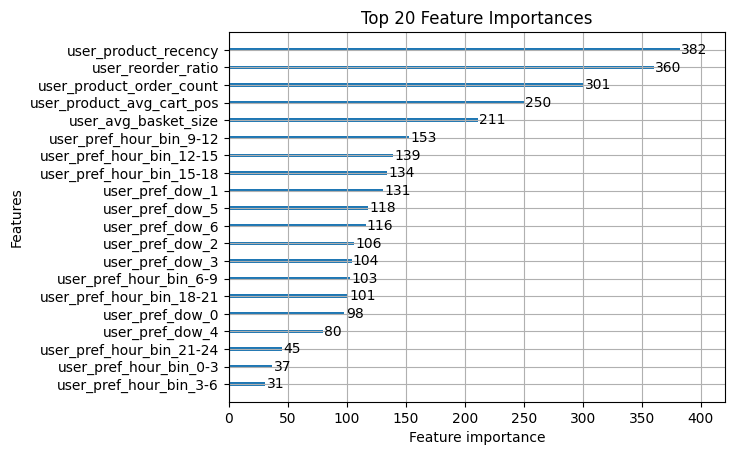

In [69]:
import matplotlib.pyplot as plt
lgb.plot_importance(model, max_num_features=20)
plt.title("Top 20 Feature Importances")
plt.show()


Tuning hyperparameters to boost recall and F1-score

In [70]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [73]:
from lightgbm import early_stopping, log_evaluation
def objective(trial):
    # Suggest hyperparameters
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'feature_pre_filter': False,
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    # Split training set again to inner train/valid
    X_train_sub, X_valid, y_train_sub, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    train_data = lgb.Dataset(X_train_sub, label=y_train_sub)
    valid_data = lgb.Dataset(X_valid, label=y_valid)

    model = lgb.train(
            param,
            train_data,
            valid_sets=[valid_data],
            callbacks=[
                early_stopping(stopping_rounds=50),
                log_evaluation(0)  # Change to 10 if you want periodic logging
            ]
        )

    y_pred = model.predict(X_valid)
    y_pred_binary = (y_pred > 0.5).astype(int)

    return f1_score(y_valid, y_pred_binary)


In [74]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

Did not meet early stopping. Best iteration is:
[56]	valid_0's binary_logloss: 0.160478


[I 2025-07-08 00:32:12,312] Trial 49 finished with value: 0.24236153377967135 and parameters: {'lambda_l1': 0.00017069387592356036, 'lambda_l2': 0.0007582854107869818, 'num_leaves': 210, 'feature_fraction': 0.8870058093187599, 'bagging_fraction': 0.5548232060433839, 'bagging_freq': 2, 'min_child_samples': 39}. Best is trial 46 with value: 0.25469476480888836.


In [75]:
print("Best F1 Score:", study.best_value)
print("Best Parameters:", study.best_params)

# Train final model on full training set using best params
best_params = study.best_params
best_params.update({'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1})

final_model = lgb.train(best_params, lgb.Dataset(X_train, label=y_train))

Best F1 Score: 0.25469476480888836
Best Parameters: {'lambda_l1': 0.0006384135740936638, 'lambda_l2': 2.2629752048107687, 'num_leaves': 243, 'feature_fraction': 0.8526022992271926, 'bagging_fraction': 0.4519748507507636, 'bagging_freq': 3, 'min_child_samples': 45}


In [76]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict probabilities
y_pred_proba = final_model.predict(X_test)

# Try different thresholds
thresholds = [0.5, 0.4, 0.35, 0.3, 0.25]

for t in thresholds:
    y_pred = (y_pred_proba > t).astype(int)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Threshold: {t}")
    print(f"→ Precision: {precision:.3f} | Recall: {recall:.3f} | F1 Score: {f1:.3f}")
    print("-" * 40)


Threshold: 0.5
→ Precision: 0.595 | Recall: 0.169 | F1 Score: 0.263
----------------------------------------
Threshold: 0.4
→ Precision: 0.526 | Recall: 0.256 | F1 Score: 0.345
----------------------------------------
Threshold: 0.35
→ Precision: 0.484 | Recall: 0.308 | F1 Score: 0.376
----------------------------------------
Threshold: 0.3
→ Precision: 0.443 | Recall: 0.365 | F1 Score: 0.400
----------------------------------------
Threshold: 0.25
→ Precision: 0.405 | Recall: 0.430 | F1 Score: 0.417
----------------------------------------


In [78]:
from sklearn.metrics import precision_recall_fscore_support

best_threshold = 0.5
best_f1 = 0
thresholds = [i / 100 for i in range(10, 60, 1)]  # Try thresholds from 0.10 to 0.59

for t in thresholds:
    y_pred = (model.predict_proba(X_test)[:, 1] > t).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"✅ Best Threshold: {best_threshold:.2f} with F1 Score: {best_f1:.4f}")


✅ Best Threshold: 0.20 with F1 Score: 0.4215


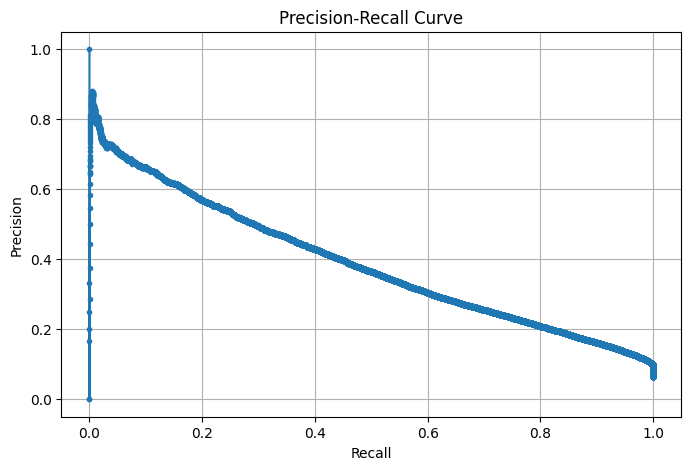

In [79]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_scores = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


In [80]:
# Assume best_threshold is found
y_pred = (model.predict_proba(X_test)[:, 1] > best_threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95    249583
         1.0       0.36      0.50      0.42     16576

    accuracy                           0.91    266159
   macro avg       0.66      0.72      0.69    266159
weighted avg       0.93      0.91      0.92    266159



In [93]:
import pickle

# Save model to file
with open('lgbm_model.pkl', 'wb') as f:
    pickle.dump(model, f)
